In [16]:
import numpy as np
from math import pow
import matplotlib.pyplot as plt

# 1D bináris Celluláris Automata (CA)

- Itt megadhatunk a CA-nak egy kezdeti tömböt: pl tiszta fehér vagy tiszta fekete cellákat tartalmazó tömb
- Megadhatunk egy initType-ot:
    - vektor: ekkor meg kell adnunk egy vektort is harmadik paraméternek, ami oszlopszám hosszú, és amit beillesztünk a kezdeti tömb első sorába
    - single: a kezdeti tömb első sorának közepére tesz egy fekete cellát
    - random: a kezdeti tömb első sora véletlenszerű lesz

In [17]:
def initial_CA(empty_CA, initType=False, vector=[]):
     if initType == 'single':
        for col in np.arange(0, columns):               
            if col == int(columns / 2) + 1:
               cell_state = 1              
            else:
               cell_state = 0
            empty_CA[0, col] = cell_state
     elif initType == 'vector':
          empty_CA[0, :] = vector  
     else:
        for col in np.arange(0, columns):              
           if np.random.random() < 0.5:  #50% chance for black or white 
              cell_state = 1
           else:
             cell_state = 0
           empty_CA[0, col] = cell_state               
     return empty_CA

Szabályrendszer megadása:
- rule_number: 0 és 255 közötti számokat adhatunk meg, amit a fv átvált egy 8 elemű bináris vektorrá, ez adja meg a bemenetekhez tartozó kimeneti értékeket
- Ez alapján ez a fv legenerál egy szótárat, hogy a 3 elemű bináris vektorokhoz milyen érték tartozik

In [18]:
def rule_dictionary(rule_number):
     pattern_dic = {}
     pattern_list = ['000','001','010','011','100','101','110','111']
    
     # I build my rule dictionary.
     for exponent in range(7, -1, -1):
        if rule_number >= pow(2, exponent):
            pattern_dic[pattern_list[exponent]] = 1
            rule_number = rule_number - pow(2, exponent)
        else:
            pattern_dic[pattern_list[exponent]] = 0
     return pattern_dic

Szimuláció lefuttatása a kezdeti tömb és a szabály alapján
- Periodikus határfeltételt használunk, vagyis a cellák a mátrixban sorfolytonosan vannak kapcsolatban egymással

In [19]:
def simulation(init_CA):
    for row in np.arange(0, rows - 1):
        for col in np.arange(0, columns):
            cell_state = init_CA[row, col]
            
            cell_pattern = str(int(init_CA[row, col - 1])) \
                        + str(int(init_CA[row, col])) \
                        + str(int(init_CA[row, (col + 1) % columns]))
            
            cell_state = pattern_dic[cell_pattern]
            
            init_CA[row + 1, col] = cell_state
        
    return init_CA

Egy 1D-s vektorunk van random feltöltve 1-kel és 0-kal (amiket betördeltünk mátrix alakba), majd 3 szomszédos bit egységekre alkalmazunk egy szabályt, hogy mi történjen adott bit hármas esetén a középső bittel.

Tehát pl a 146-es szabály (binárisan 146 = 10010010, ami lentről felfelé olvasva a kimenet):
        - 000 0
        - 001 1
        - 010 0
        - 011 0
        - 100 1
        - 101 0
        - 110 0
        - 111 1

Az az érdekes ebben, hogy ilyen egyszerű szabályokkal is kialakíthatóak kaotikus és reguláris mintázatok véletlenszerű elrendezésekből, és pl a 110-es szabály még Turing teljes is, és használható bármilyen számítás elvégzésére.

Mivel 3 bit 2^3 = 8 különböző módon állítható össze, ezért ezekhez egy 8 elemű bitvektor fog tartozni (a szabály). Ez pedig 2^8 = 256 értéket vehet fel, így összesen ennyi szabályt határozhatunk meg.

A szabályok között szimmetria csoportok fedezhetők fel, amiknek hasonló a funkciója.

- Minden szabálynak van komplemense, ami ugyanazt csinálja, mint a szabály, csak a fekete és fehér mezők fel lesznek cserélve. (inverz)
- Van bal-jobb ekvivalens, ami olyan, mintha tükröznénk a bemenetet.
- És van bal-jobb komplemens, ami az inverznek a tükörképe.

Tehát a 256 szabály nem független, 4-esével csoportosíthatók. Viszont nem is 256/4 = 64 független szabály lesz, hanem 88, mivel bizonyos szabályok megegyezhetnek a szimmetria csoportjukban lévő szabályokkal. (pl 0-s csoport bal/jobb ekvivalense önmaga).

A szabályok közt vannak Turing teljesek, kaotikusak és regulárisak is.

000 1
001 1
010 1
011 0
100 0
101 0
110 1
111 1


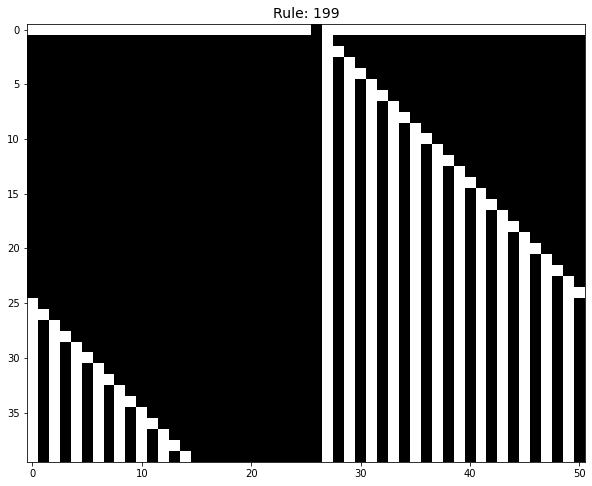

In [24]:
rule = 199
pattern_dic= rule_dictionary(rule)
for x in reversed(pattern_dic):
  print(x,pattern_dic[x])

rows = 40
columns = 51
empty_CA = np.zeros([rows, columns])
Init=np.random.randint(0,2,columns)
init_CA = initial_CA(empty_CA,initType ='single')
# init_CA = initial_CA(empty_CA,initType ='vector',vector=Init)
result_CA= simulation(init_CA)

fig1= plt.figure (figsize = (10,20))
plt.imshow(result_CA, vmin= 0, vmax= 1, cmap= 'binary')
plt.axis('image')
plt.title('Rule: '+ str(rule), fontsize=14)
plt.show()

# Nevezetes szabályok
- 30: kaotikus
- 65: szabályos mintázat
- 110: Turing teljes szerkezet, van struktúrája
- 240: a baloldali szomszédját másolja, így egy eltolás történik

# Egy négyescsoport (vierergruppe) vizsgálata:

- Vegyük a 146-os szabályt: 10010010
    - Komplemens: 10110110 = 182
        - a bemenet inverzéhez kerül a kimenet inverze
        - pl: 000-hoz kerül az 111-nél lévő 1-es ellentéte, azaz a 0
                - 000 0 0
                - 001 1 1
                - 010 0 1
                - 011 0 0
                - 100 1 1
                - 101 0 1
                - 110 0 0
                - 111 1 1
    - Bal-jobb ekvivalens = 146
        - a bemenetet számjegyeit tükrözzük a középső számjegyre, és az annak megfelelő bemenet értékét kapja meg
        - pl: 001 bemenet tükörképe az 100, és ennek az értéke 1
                - 000 0 0
                - 001 1 1
                - 010 0 0
                - 011 0 0
                - 100 1 1
                - 101 0 0
                - 110 0 0
                - 111 1 1
    - Bal-jobb komplemens = 182
        - kétféleképpen is számolható:
            - Komplemens bal-jobb ekvivalense
            - Bal-jobb ekvivalens komplemense
                    - 000 0 0
                    - 001 1 1
                    - 010 0 0
                    - 011 0 0
                    - 100 1 1
                    - 101 0 0
                    - 110 0 0
                    - 111 1 1

Add meg annak az egy-dimenziós celluláris automata szabálynak az igazságtáblázatát és számát, amely NAND műveletet valósít meg a bal oldali szomszéd és a középső elem állapota között:

    NAND:
    - 0 0 1
    - 0 1 1
    - 1 0 1
    - 1 1 0

    - 000 1
    - 001 1
    - 010 1
    - 011 1
    - 100 1
    - 101 1
    - 110 0
    - 111 0

00111111 = 63